In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import recall_score, make_scorer, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

from app.functions.process_url import *
#  

# Dataset loading and creating features

In [21]:
data = pd.read_csv('../data/dataset_url.csv')

features = data['url'].apply(extract_features)

data = pd.concat([data, features], axis=1)
data.drop('url', axis=1, inplace=True)
# changing labels to numeric format
data.loc[data['label'] == 'bad', 'label'] = 1
data.loc[data['label'] == 'good', 'label'] = 0
data['label'] = data['label'].astype(int)


In [14]:
print(data.columns)
print(data.head())

Index(['label', 'NumDots', 'PathLevel', 'UrlLength', 'NumDash',
       'NumDashInHostname', 'AtSymbol', 'TildeSymbol', 'NumUnderscore',
       'NumUnderscoreInHostname', 'NumPercent', 'NumQueryComponents',
       'NumAmpersand', 'NumHash', 'NumNumericChars', 'PathLength',
       'DoubleSlashInPath', 'Entropy', 'SchemeHTTPS', 'DomainLength',
       'PathSegmentsLength', 'PresenceSpecificTLDs', 'CountSensitiveWords',
       'ProportionAlphaChars', 'SubdomainLength', 'PositionLastDot',
       'UppercaseCount', 'SpecialCharsProportion', 'NonLatinChars',
       'FileExtensionLength', 'URLEncoding'],
      dtype='object')
   label  NumDots  PathLevel  UrlLength  NumDash  NumDashInHostname  AtSymbol  \
0      1        1          0         22        0                  0     False   
1      1        2          0         16        0                  0     False   
2      1        1          0         18        0                  0     False   
3      1        1          0         13        0    

# Exploratory data analysis

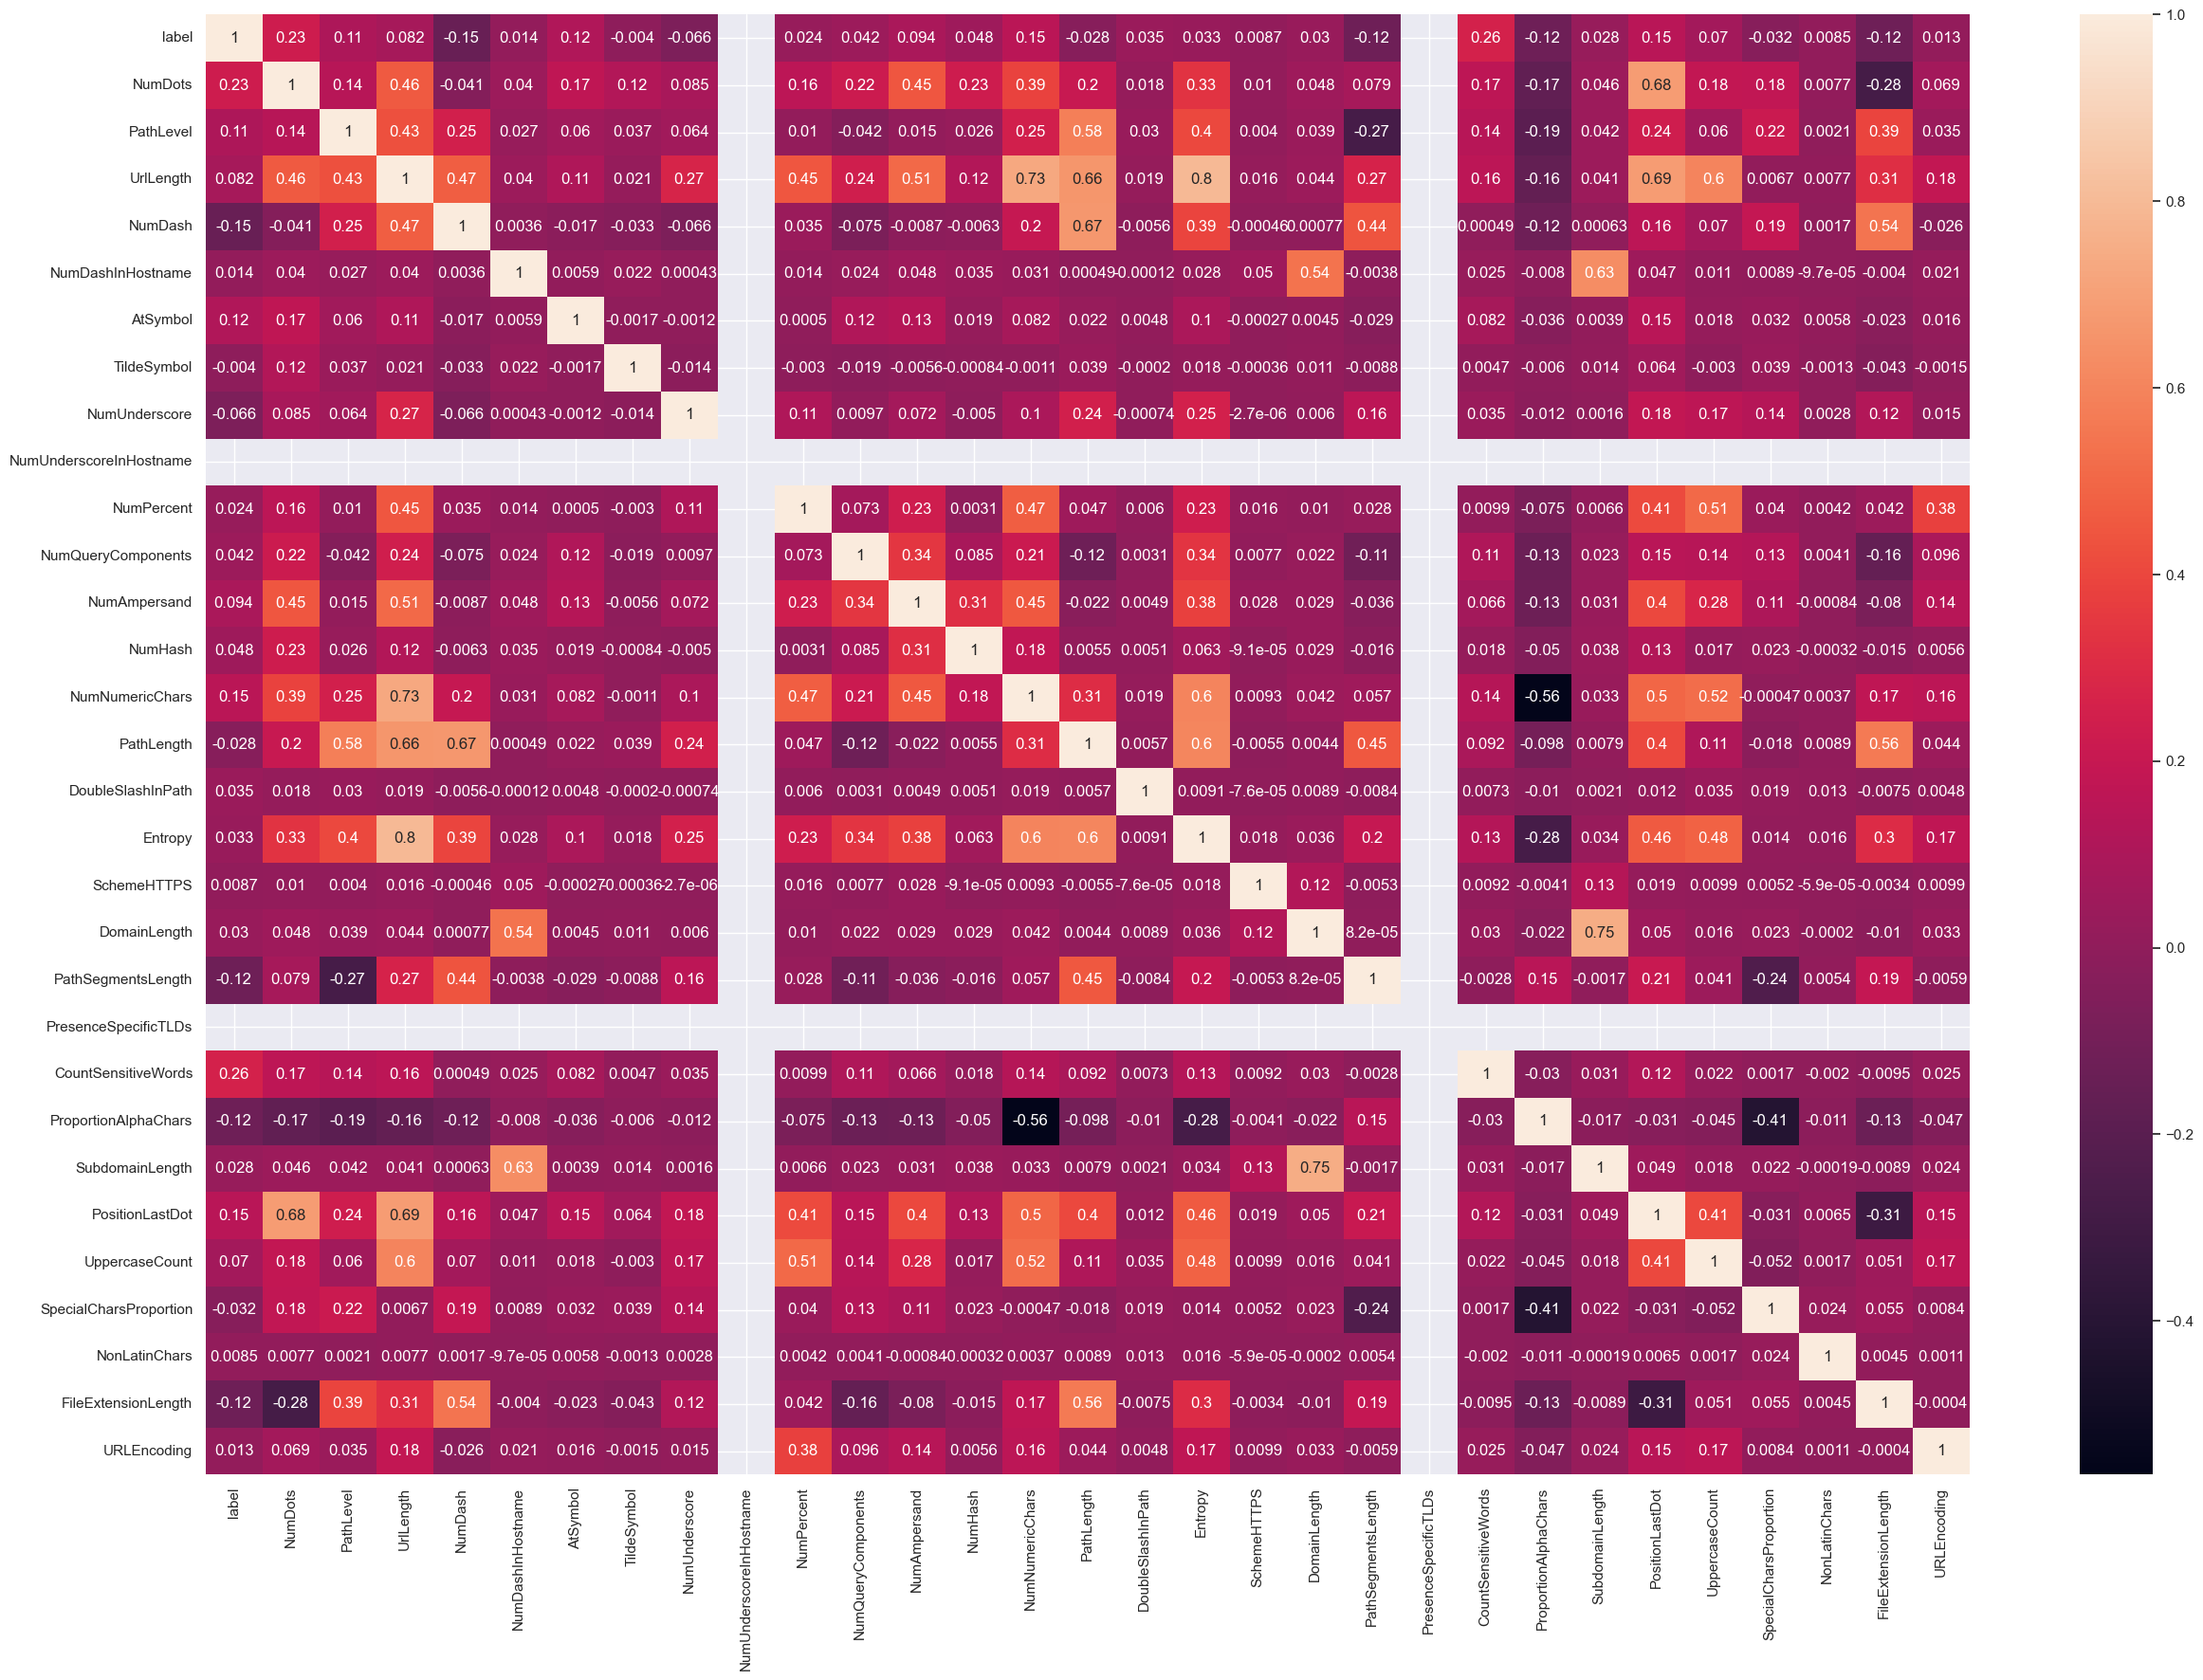

In [4]:
#Features correlation plot
sns.set(rc={'figure.figsize': (30, 20)})
sns.heatmap(data.corr(), annot=True)
plt.show()


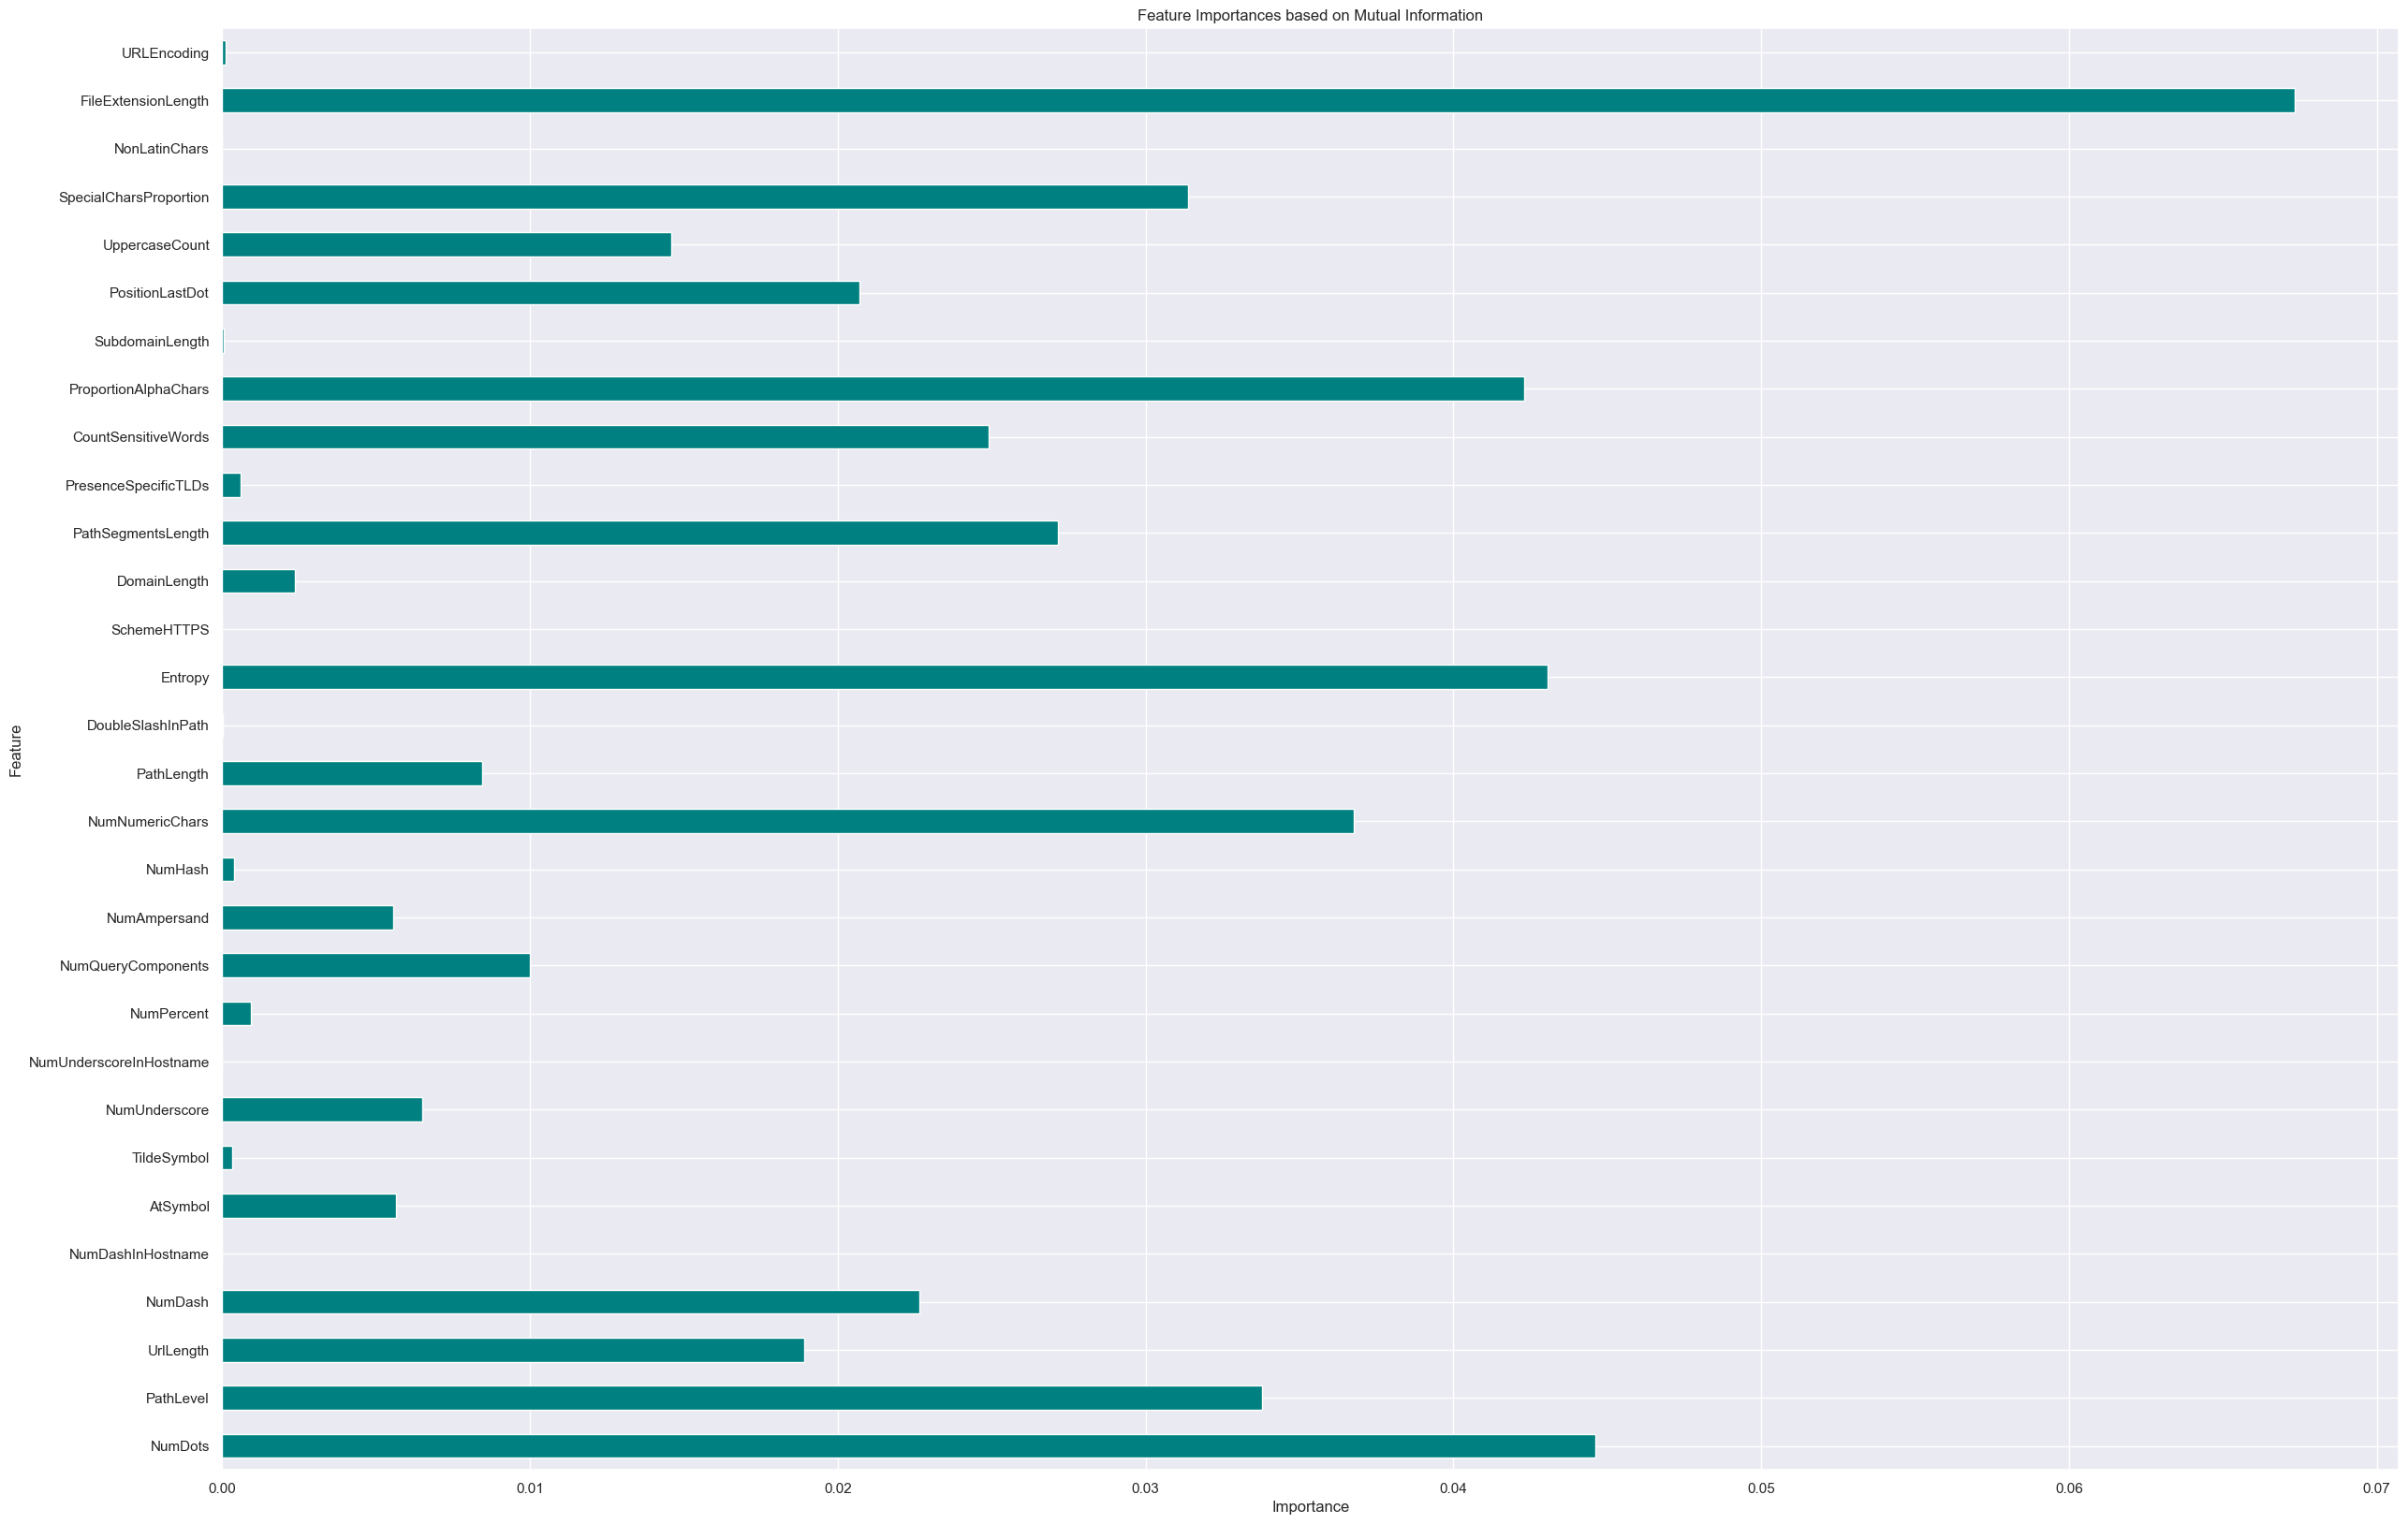

In [5]:
import pandas as pd
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and 'Label' is your response variable
X = data.drop(columns=['label'])
y = data['label']

# Calculate mutual information
importances = mutual_info_classif(X, y)

# Create a Series to visualize the feature importances
feat_importances = pd.Series(importances, index=X.columns)

# Plot the feature importances
feat_importances.plot(kind='barh', color='teal')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances based on Mutual Information')
plt.show()


Removing features


In [22]:
not_important_features = ['URLEncoding','NumDashInHostname','SubdomainLength','PresenceSpecificTLDs','DomainLength','DoubleSlashInPath','NumHash','NumPercent','NumUnderscoreInHostname','TildeSymbol','NonLatinChars','PresenceSpecificTLDs','SchemeHTTPS']
data_droped_features=data.drop(not_important_features, axis=1, inplace=False)

In [23]:
print(data_droped_features.columns)

Index(['label', 'NumDots', 'PathLevel', 'UrlLength', 'NumDash', 'AtSymbol',
       'NumUnderscore', 'NumQueryComponents', 'NumAmpersand',
       'NumNumericChars', 'PathLength', 'Entropy', 'PathSegmentsLength',
       'CountSensitiveWords', 'ProportionAlphaChars', 'PositionLastDot',
       'UppercaseCount', 'SpecialCharsProportion', 'FileExtensionLength'],
      dtype='object')


In [24]:
# class inbalance check
print(len(data[data['label']==1]))
print(len(data[data['label']==0]))


75643
344821


# Training models with all features

In [25]:
def oversample_minority_class(x, y):
    minority_class = y.value_counts().idxmin()
    num_samples_minority = y.value_counts().max() - y.value_counts().min()

    minority_indices = y[y == minority_class].index
    random_indices = np.random.choice(minority_indices, size=num_samples_minority, replace=True)

    x_oversampled = pd.concat([x, x.loc[random_indices]], ignore_index=True)
    y_oversampled = pd.concat([y, y.loc[random_indices]], ignore_index=True)

    return x_oversampled, y_oversampled


Random Forest best parameters: {'max_depth': 60, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}
Random Forest validation recall score: 0.8110430529238091
Logistic Regression best parameters: {'C': 10, 'max_iter': 100, 'solver': 'newton-cg'}
Logistic Regression validation recall score: 0.7311946415194113
Decision Tree best parameters: {'max_depth': 60, 'min_samples_leaf': 1, 'min_samples_split': 2}
Decision Tree validation recall score: 0.7713391794826598


D:\Projekty\ML_project\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:43:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


XGBoost best parameters: {'learning_rate': 0.1, 'max_depth': 30, 'min_child_weight': 1, 'n_estimators': 500, 'subsample': 0.9}
XGBoost validation recall score: 0.8164191600934209


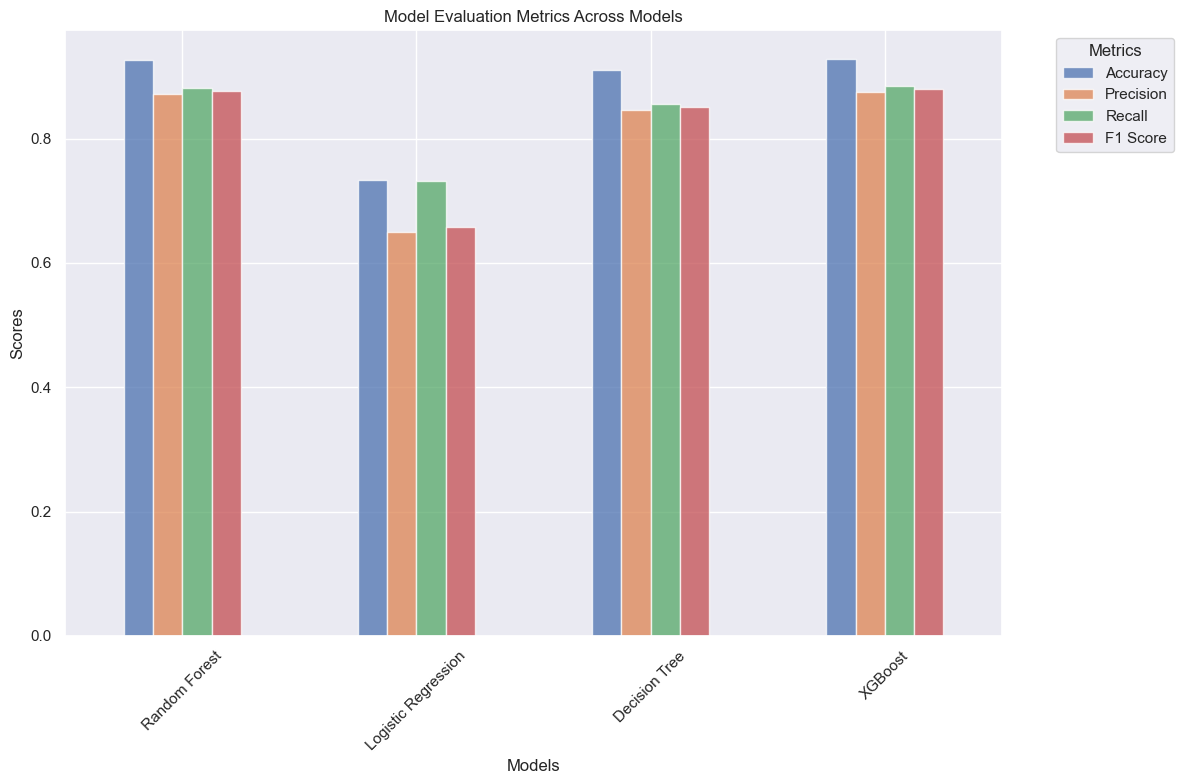

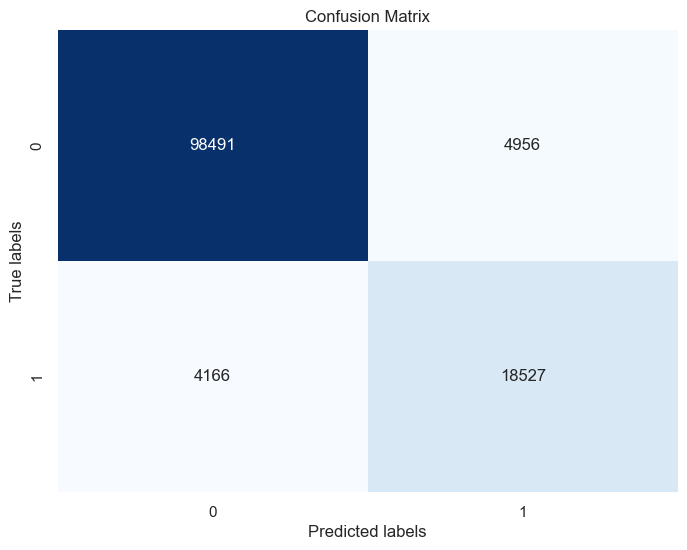

In [26]:
X = data.drop(['label'], axis=1)
y = data['label']
X.columns = [f'f{i}' for i in range(X.shape[1])]

major_classs= np.argmax([len(y[y==cl]) for cl in np.unique(y)])

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42, stratify=y)


# Resample the training data
X_train, y_train = oversample_minority_class(X_train, y_train)



param_grid_rf = {
    'n_estimators': [500, 1000],
    'max_depth': [30, 60],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 5]
}

param_grid_lr = {
    'C': [0.01, 10],
    'solver': ['newton-cg', 'liblinear'],
    'max_iter': [100, 300]
}

param_grid_dt = {
    'max_depth': [20, 60],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 5]
}

param_grid_xgb = {
    'n_estimators': [200, 500],
    'max_depth': [10, 30],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.6, 0.9],
    'min_child_weight': [1, 5]
}

# Initialize models with GridSearchCV
models = {
    'Random Forest': GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5,n_jobs=13),
    'Logistic Regression': GridSearchCV(LogisticRegression(), param_grid_lr, cv=5,n_jobs=13),
    'Decision Tree': GridSearchCV(DecisionTreeClassifier(), param_grid_dt, cv=5,n_jobs=13),
    'XGBoost': GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss',device='cuda'), param_grid_xgb, cv=5)

}


best_models = {}
validation_results = {}


for model_name, model in models.items():
    model.fit(X_train, y_train)
    best_models[model_name] = model.best_estimator_
    y_val_pred = model.predict(X_test)
    recall = recall_score(y_test, y_val_pred)
    
    validation_results[model_name] = recall
    print(f"{model_name} best parameters: {model.best_params_}")
    print(f"{model_name} validation recall score: {recall}")


model_metrics = {}

for model_name, model in best_models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    model_metrics[model_name] = {
        'Accuracy': accuracy,
        'Precision': report['macro avg']['precision'],
        'Recall': report['macro avg']['recall'],
        'F1 Score': report['macro avg']['f1-score']
    }

metrics_df = pd.DataFrame(model_metrics).T

fig, ax = plt.subplots(figsize=(12, 8))
metrics_df.plot(kind='bar', ax=ax, alpha=0.75, rot=0)
ax.set_title('Model Evaluation Metrics Across Models')
ax.set_ylabel('Scores')
ax.set_xlabel('Models')
ax.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# confusion matrix of best model
model=best_models['XGBoost']
y_test_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()



## Training models without unimportant features

Random Forest best parameters: {'max_depth': 60, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Random Forest validation recall score: 0.8095447935486714
Logistic Regression best parameters: {'C': 10, 'max_iter': 100, 'solver': 'liblinear'}
Logistic Regression validation recall score: 0.729387916978804
Decision Tree best parameters: {'max_depth': 60, 'min_samples_leaf': 1, 'min_samples_split': 2}
Decision Tree validation recall score: 0.7671969329749262
XGBoost best parameters: {'learning_rate': 0.1, 'max_depth': 30, 'min_child_weight': 1, 'n_estimators': 500, 'subsample': 0.9}
XGBoost validation recall score: 0.8135107742475653


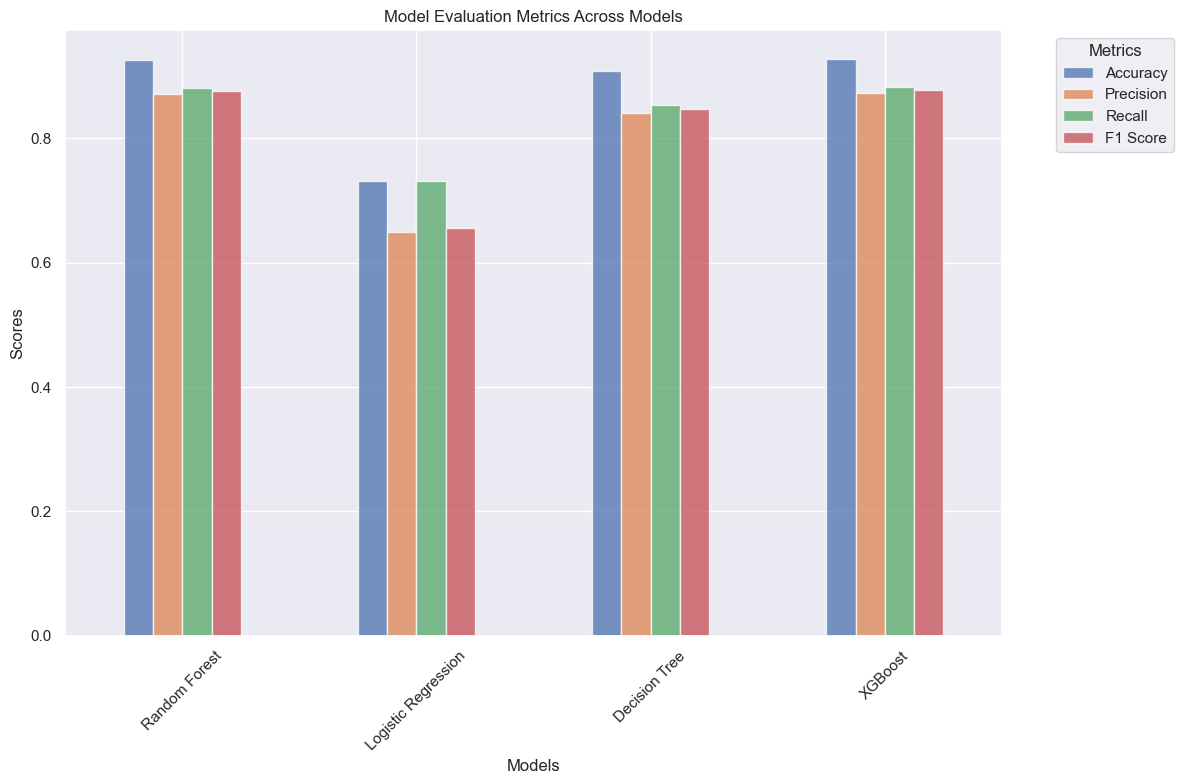

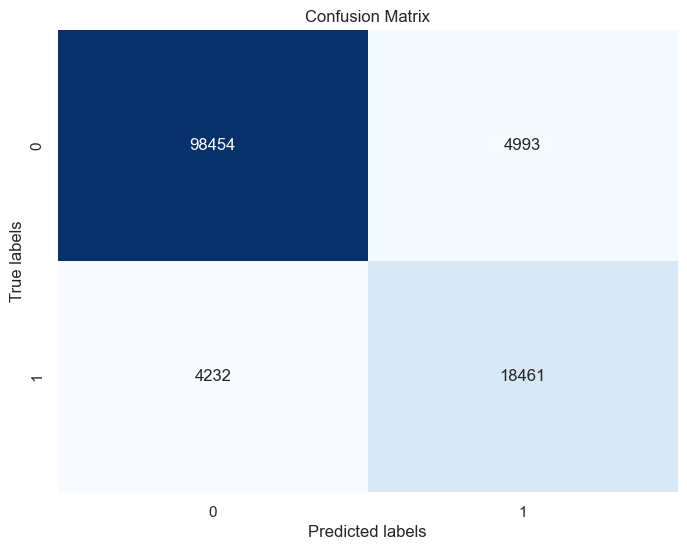

In [27]:
X = data_droped_features.drop(['label'], axis=1)
y = data_droped_features['label']
X.columns = [f'f{i}' for i in range(X.shape[1])]

major_classs= np.argmax([len(y[y==cl]) for cl in np.unique(y)])

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42, stratify=y)


# Resample the training data
X_train, y_train = oversample_minority_class(X_train, y_train)



param_grid_rf = {
    'n_estimators': [500, 1000],
    'max_depth': [30, 60],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 5]
}

param_grid_lr = {
    'C': [0.01, 10],
    'solver': ['newton-cg', 'liblinear'],
    'max_iter': [100, 300]
}

param_grid_dt = {
    'max_depth': [20, 60],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 5]
}

param_grid_xgb = {
    'n_estimators': [200, 500],
    'max_depth': [10, 30],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.6, 0.9],
    'min_child_weight': [1, 5]
}



# Initialize models with GridSearchCV
models = {
    'Random Forest': GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5,n_jobs=13),
    'Logistic Regression': GridSearchCV(LogisticRegression(), param_grid_lr, cv=5,n_jobs=13),
    'Decision Tree': GridSearchCV(DecisionTreeClassifier(), param_grid_dt, cv=5,n_jobs=13),
    'XGBoost': GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss',device='cuda'), param_grid_xgb, cv=5)

}


best_models = {}
validation_results = {}


for model_name, model in models.items():
    model.fit(X_train, y_train)
    best_models[model_name] = model.best_estimator_
    y_val_pred = model.predict(X_test)
    recall = recall_score(y_test, y_val_pred)
    
    validation_results[model_name] = recall
    print(f"{model_name} best parameters: {model.best_params_}")
    print(f"{model_name} validation recall score: {recall}")


model_metrics = {}

for model_name, model in best_models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    model_metrics[model_name] = {
        'Accuracy': accuracy,
        'Precision': report['macro avg']['precision'],
        'Recall': report['macro avg']['recall'],
        'F1 Score': report['macro avg']['f1-score']
    }

metrics_df = pd.DataFrame(model_metrics).T

fig, ax = plt.subplots(figsize=(12, 8))
metrics_df.plot(kind='bar', ax=ax, alpha=0.75, rot=0)
ax.set_title('Model Evaluation Metrics Across Models')
ax.set_ylabel('Scores')
ax.set_xlabel('Models')
ax.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# confusion matrix of best model
model=best_models['XGBoost']
y_test_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


